In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import sys

import csv

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
#csvのパスを設定
csv_path = "C:\\Users\\meida\\lab_materials\\M1\\pems\\data\\integrated_route.csv"
#corr_path = "C:\\Users\\meida\\lab_materials\\M1\\pems\\data\\corr.csv"

In [3]:
df = pd.read_csv(csv_path,index_col=0)
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]
df = df.dropna(axis=1)
date_time = pd.to_datetime(df.pop('5 Minutes'), format='%Y.%m.%d %H:%M:%S')

In [4]:
#相関係数0.8以上（11個）
#df = df.loc[:,['11750', '18828', '18830', '275', '4649', '4651', '6224', '6225', '78','79', '81']]

#近くの経路（96個）
#df = df.loc[:,['11750', "4649","79","6225","18830","81","275","78","18828","6224","19835","2132","14467","4648","77","82","80","372","19837","6670","86","6218","6221","271","6679","18862","18846","85","6680","18860","6215","274","13867","18852","276","2135","6220","6202","365","6678","366","413","359","18820","88","379","16207","360","6701","6669","6203","19979","367","6216","6616","6700","6662","6214","272","361","6606","2131","2134","363","18822","87","6665","22622","6200","6666","18850","6217","18832","6671","6604","6605","6219","6663","3394","19981","6201","6601","6675","362","18854","18856","18834","6600","6603","6602","6705","6664","6615","6674","6673","18858"]]

#相関係数0.7以上（77個）
#df = df.loc[:,['11750', '13147', '13867', '14467', '16507', '16509', '16510', '16511','18174', '18824', '18828', '18830', '18836', '18838', '18840', '18846','18852', '18860', '18862', '18868', '18872', '19835', '19837', '19839','19955', '20274', '2132', '2133', '2135', '271', '274', '275', '276','358', '365', '366', '369', '372', '373', '412', '425', '434', '4647','4648', '4649', '4650', '4651', '471', '571', '6202', '6210', '6212', '6215', '6218', '6220', '6221', '6222', '6224', '6225', '6226', '6227','6641', '6670', '6677', '6678', '6679', '6680', '6723', '77', '78','79', '80', '81', '82', '83', '85', '86']]

#ＤＴＷで11個選ぶ
#df = df.loc[:,['11750','4649','79','6225','18830','6224','18828','81','18174','4651','16507']]

In [5]:
shift = 6
n_input = 30
input_width = 24
ran = 200

In [6]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels



In [7]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

In [8]:
def make_test_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds



In [9]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_test_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



In [10]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [11]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
                #metrics=[tf.metrics.MeanAbsoluteError()])

  start = time.time()
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val
                      #callbacks=[early_stopping]
                     )
  run_time = time.time() - start
  return history,run_time

In [12]:
def process1(df, target):
    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    df_std = (df - train_mean) / train_std
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    
    class WindowGenerator():
      def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

      def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[target])
    
    WindowGenerator.split_window = split_window
    
    # Stack three slices, the length of the total window.
    example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                               np.array(train_df[100:100+w2.total_window_size]),
                               np.array(train_df[200:200+w2.total_window_size])])

    example_inputs, example_labels = w2.split_window(example_window)

    w2.example = example_inputs, example_labels
    
    WindowGenerator.make_dataset = make_dataset
    WindowGenerator.make_test_dataset = make_test_dataset
    
    WindowGenerator.train = train
    WindowGenerator.val = val
    WindowGenerator.test = test
    WindowGenerator.example = example
    
    single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[target])


    val_performance = {}
    performance = {}
    
    
    wide_window = WindowGenerator(
        input_width=input_width, label_width=1, shift=shift,
        label_columns=[target])

    #wide_window = WindowGenerator(
    #input_width=24, label_width=24, shift=1,
    #label_columns=[target])
    
    lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.LSTM(300, return_sequences=True),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
    ])
    
    history,run_time = compile_and_fit(lstm_model, wide_window)
    IPython.display.clear_output()
    val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
    performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
    lstm_predict = lstm_model.predict(wide_window.test, verbose=0)
    
    plt.plot([i for i in range(ran)],test_df[target][input_width+shift-1:ran+input_width+shift-1],color="red")
    plt.plot([i for i in range(ran)],np.ravel(lstm_predict[0:ran]),color="blue")
    plt.show()
    
    del df,df_std,test_df,train_df,train_mean,train_std,val_df
    
    return run_time,val_performance['LSTM'][1],performance['LSTM'][1]

In [13]:
output_path = "C:\\Users\\meida\\lab_materials\\M1\\pems\\output\\xcorr_top_30.csv"

In [14]:
with open(output_path,"w") as f:
    writer = csv.writer(f)
    writer.writerow(["route","runtime","val_performance","performance","input","input_num"])

## 相関係数で特徴選択

def select_index(target):

    #相関係数
    corrs = []
    for c in df.columns:
        corr = np.corrcoef(df[c],df[target])[0,1]
        corrs.append(corr)
    corrs = np.array(corrs)

    #重要度の上位を出力
    idx_corrs = np.argsort(np.abs(corrs))[::-1]
    top_cols_corrs,top_importances_corrs = df.columns.values[idx_corrs][:n_input],corrs[idx_corrs][:n_input]
    print(top_cols_corrs,top_importances_corrs)

    top_cols_select = top_cols_corrs
    
    return top_cols_select
    #return [str(target)]

## 相互相関係数で特徴選択

In [15]:
def select_index(target):

    #相互相関関数
    corrs = []
    lags = []
    for c in df.columns:
        xcorr_list = xcorr(df[target],df[c])
        lag = np.argmax(np.abs(xcorr_list))
        lags.append(lag)
        corr = corr_lag(df[target],df[c],lag)
        corrs.append(corr)
    corrs = np.array(corrs)
    lags = np.array(lags) #targetと各routeでのラグを格納
    
    #重要度の上位を出力
    idx_corrs = np.argsort(np.abs(corrs))[::-1]
    top_cols_corrs,top_importances_corrs,lags = df.columns.values[idx_corrs][:n_input],corrs[idx_corrs][:n_input],lags[idx_corrs][:n_input]
    print(top_cols_corrs,top_importances_corrs,lags)
    
    #targetのインデックスを追加
    if not target in top_cols_corrs:
        top_cols_corrs = np.append(top_cols_corrs,target)
    
    top_cols_select = top_cols_corrs
    
    return top_cols_select
    #return [str(target)]
    
def xcorr(target,c):
    xcorr_list = []
    #margin = np.zeros(24)
    #target = np.block([target,margin])
    #c = np.block([margin,c])
    
    for t in range(24):
        score = np.dot(target[t:],c[:len(c)-t])/(len(target)-t)
        xcorr_list.append(score)
        
    return xcorr_list

def corr_lag(target,c,lag):
    return np.corrcoef(target[lag:],c[:len(c)-lag])[0,1]

## 相関○○以上

for target in df.columns:
    #corr_index = df.index.values
    corr_index = []
    index_list = df_corr[df_corr[target]>thre].index.values
    for i in index_list:
        corr_index.append(str(i))
    df_input = df.loc[:,corr_index]
    
    print(target)
    print(df_input.columns)
    run_time, val_performance, performance = process1(df_input,target)
    print(run_time)
    #print(val_performance)
    print(performance)
    
    output = []
    output.append(target)
    output.append(run_time)
    output.append(val_performance)
    output.append(performance)
    output.append(corr_index)
    output.append(len(corr_index))
    
    with open(output_path,"a") as f:
        writer = csv.writer(f)
        writer.writerow(output)

## 相関上位○○個

500/500 [==============================] - 2s 3ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374


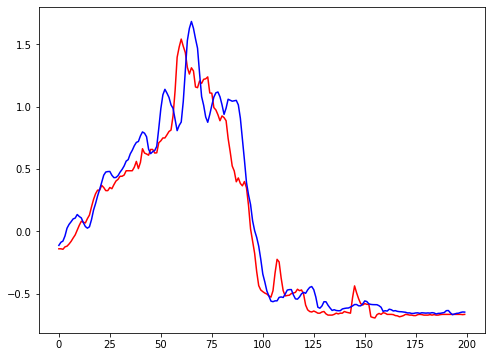

247.5281059741974
0.1447020173072815
['14467' '372' '19835' '19837' '18828' '6224' '6225' '18830' '78' '77'
 '271' '16509' '6215' '18846' '83' '13867' '18860' '6221' '6679' '18862'
 '6680' '6677' '6212' '2133' '6650' '6220' '4651' '6723' '16507' '275'] [1.         0.97521698 0.96807688 0.90893136 0.9043274  0.9033354
 0.89834062 0.89653398 0.89613815 0.88720818 0.88655182 0.8848853
 0.88373009 0.88194992 0.87785224 0.87347286 0.87177847 0.87158165
 0.8714746  0.87137382 0.8699773  0.86983293 0.86915785 0.86663958
 0.86655479 0.86575266 0.86429483 0.86338238 0.8627926  0.86214208] [0 0 2 0 6 6 4 4 5 0 0 1 0 0 0 0 0 0 0 0 0 0 0 4 0 0 1 0 2 0]
14467
Index(['14467', '372', '19835', '19837', '18828', '6224', '6225', '18830',
       '78', '77', '271', '16509', '6215', '18846', '83', '13867', '18860',
       '6221', '6679', '18862', '6680', '6677', '6212', '2133', '6650', '6220',
       '4651', '6723', '16507', '275'],
      dtype='object')
Epoch 1/20
1752/1752 [==============================

In [ ]:
for target in df.columns:
    top_cols_select = select_index(target)
    df_input = df[top_cols_select]
    
    print(target)
    print(df_input.columns)
    run_time, val_performance, performance = process1(df_input,target)
    print(run_time)
    #print(val_performance)
    print(performance)
    
    output = []
    output.append(target)
    output.append(run_time)
    output.append(val_performance)
    output.append(performance)
    output.append(top_cols_select)
    output.append(len(top_cols_select))
    
    with open(output_path,"a") as f:
        writer = csv.writer(f)
        writer.writerow(output)